# motion estimation in spikeinterface

In 2021,the SpikeInterface project has started to implemented `sortingcomponents`, a modular module for spike sorting steps.

Here is an overview or our progress integrating motion (aka drift) estimation and correction.


This notebook will be based on the open dataset from Nick Steinmetz published in 2021
"Imposed motion datasets" from Steinmetz et al. Science 2021
https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495


The motion estimation is done in several modular steps:
  1. detect peaks
  2. localize peaks:
     * **"center of of mass"**
     * **"monopolar_triangulation"** by Julien Boussard and Erdem Varol
       https://openreview.net/pdf?id=ohfi44BZPC4
  3. estimation motion:
     * **rigid** or **non rigid**
     * **"decentralize"** by Erdem Varol and  Julien Boussard
       DOI : 10.1109/ICASSP39728.2021.9414145
     * **"motion cloud"** by Julien Boussard (not implemented yet)


Here we will show this chain:
* **detect peak > localize peaks with "monopolar_triangulation" > estimation motion "decentralize"**










In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12)

from probeinterface.plotting import plot_probe


/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/datalad/cmd.py:375: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  new_loop = True
/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/spikeinterface/core/datasets.py:12: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  HAVE_DATALAD = False


In [3]:
# local folder
base_folder = Path('/mnt/data/sam/DataSpikeSorting/imposed_motion_nick')

dataset_folder = base_folder / 'dataset1/NP1'
preprocess_folder = base_folder / 'dataset1_NP1_preprocessed'
peak_folder = base_folder / 'dataset1_NP1_peaks'

peak_folder.mkdir(exist_ok=True)

In [4]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=40,
    chunk_memory='10M',
    progress_bar=True,
)

In [5]:
# read the file
rec = si.read_spikeglx(dataset_folder)
rec

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1957.191s

(-150.0, 200.0)

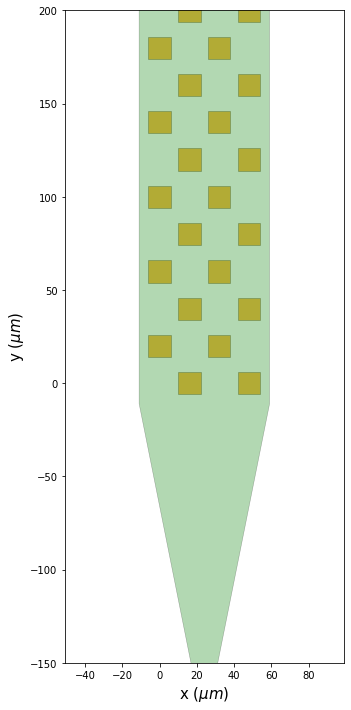

In [7]:
fig, ax = plt.subplots()
si.plot_probe_map(rec, ax=ax)
ax.set_ylim(-150, 200)

## preprocess

This take 4 min for 30min of signals

In [8]:
if not preprocess_folder.exists():
    rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000.)
    rec_preprocessed = si.common_reference(rec_filtered, reference='global', operator='median')
    rec_preprocessed.save(folder=preprocess_folder, **job_kwargs)
rec_preprocessed = si.load_extractor(preprocess_folder)

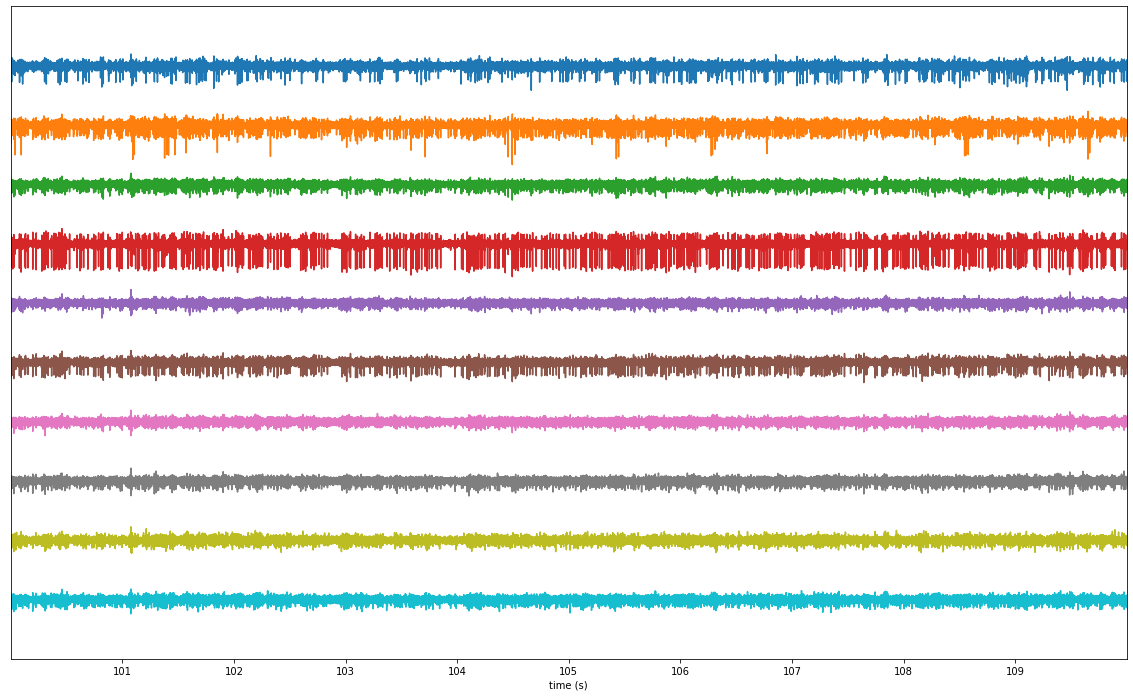

In [9]:
# plot and check spikes
si.plot_timeseries(rec_preprocessed, time_range=(100, 110), channel_ids=rec.channel_ids[50:60])

## estimate noise

Text(0.5, 1.0, 'noise across channel')

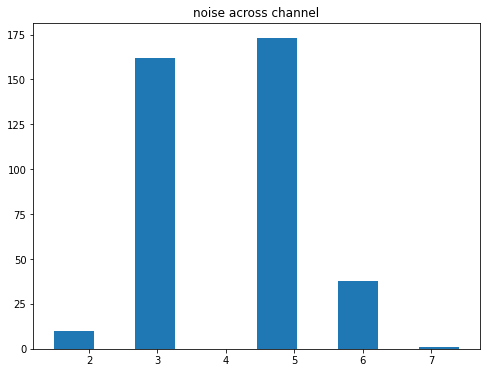

In [13]:
noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(noise_levels, bins=10)
ax.set_title('noise across channel')

## detect peaks

This take 1min30s

In [11]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [14]:
if not (peak_folder / 'peaks.npy').exists():
    peaks = detect_peaks(
        rec_preprocessed,
        method='locally_exclusive',
        local_radius_um=100,
        peak_sign='neg',
        detect_threshold=5,
        n_shifts=5,
        noise_levels=noise_levels,
        **job_kwargs,
    )
    np.save(peak_folder / 'peaks.npy', peaks)
peaks = np.load(peak_folder / 'peaks.npy')
print(peaks.shape)

(4041179,)


## localize peaks

Here we chosse **'monopolar_triangulation' with log barrier**

In [18]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

In [16]:
if not (peak_folder / 'peak_locations_monopolar_triangulation_log_limit.npy').exists():
    peak_locations = localize_peaks(
        rec_preprocessed,
        peaks,
        ms_before=0.3,
        ms_after=0.6,
        method='monopolar_triangulation',
        method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000., 'optimizer': 'minimize_with_log_penality'},
        **job_kwargs,
    )
    np.save(peak_folder / 'peak_locations_monopolar_triangulation_log_limit.npy', peak_locations)
    print(peak_locations.shape)
peak_locations = np.load(peak_folder / 'peak_locations_monopolar_triangulation_log_limit.npy')

In [17]:

print(peak_locations)

[( 18.81849235, 1782.84538913,  78.17532357, 1696.96239445)
 ( 31.90279769, 3847.75061369, 134.79844077, 1716.03155721)
 (-23.12038001, 2632.87834759,  87.76916268, 2633.62546695) ...
 ( 40.0839554 , 1977.83852796,  26.50998809, 1092.53885299)
 (-51.40036701, 1772.34521905, 170.65660676, 2533.03617278)
 ( 54.3813594 , 1182.28971165,  87.35020554, 1303.53392431)]


## plot on probe

(1800.0, 2500.0)

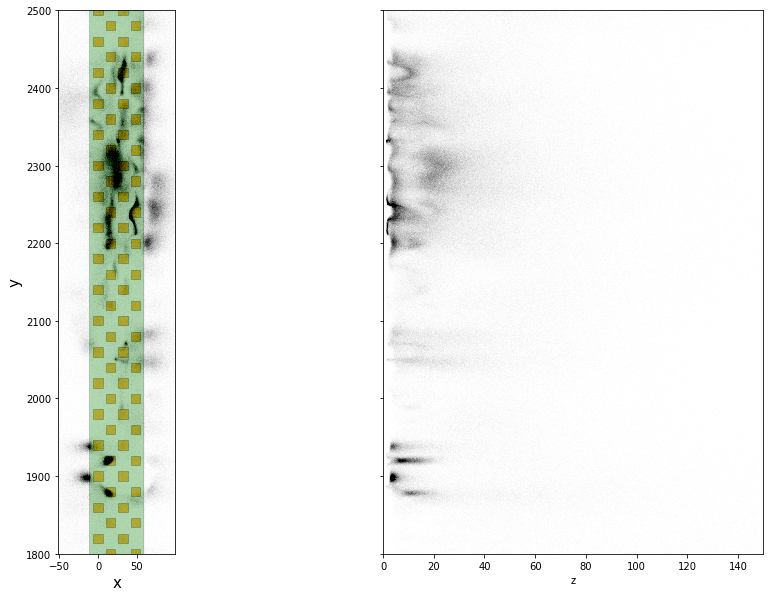

In [22]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
ax = axs[0]
si.plot_probe_map(rec_preprocessed, ax=ax)
ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.002)
ax.set_xlabel('x')
ax.set_ylabel('y')
if 'z' in peak_locations.dtype.fields:
    ax = axs[1]
    ax.scatter(peak_locations['z'], peak_locations['y'], color='k', s=1, alpha=0.002)
    ax.set_xlabel('z')
    ax.set_xlim(0, 150)
ax.set_ylim(1800, 2500)

## plot peak depth vs time

(1300.0, 2500.0)

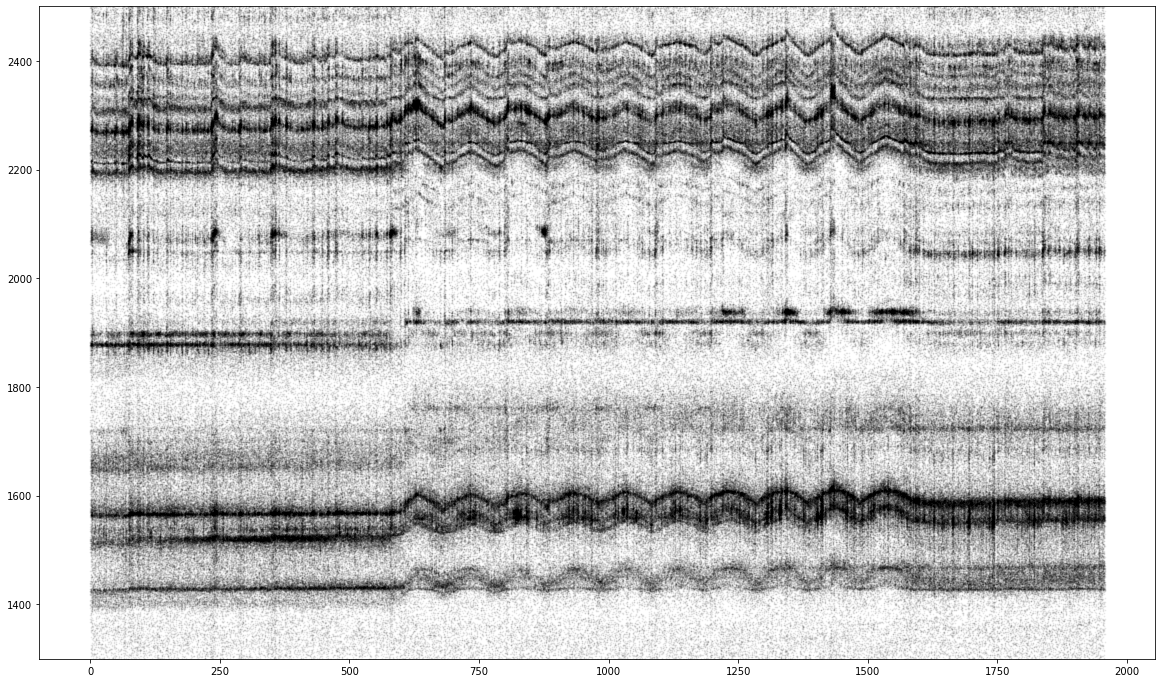

In [23]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
ax.set_ylim(1300, 2500)

## motion estimate : rigid with decentralized

In [25]:
from spikeinterface.sortingcomponents.motion_estimation import (
    estimate_motion,
    make_motion_histogram,
    compute_pairwise_displacement,
    compute_global_displacement
)

In [45]:
bin_um = 5
bin_duration_s=5.

motion_histogram, temporal_bins, spatial_bins = make_motion_histogram(
    rec_preprocessed,
    peaks,
    peak_locations=peak_locations, 
    bin_um=bin_um,
    bin_duration_s=bin_duration_s,
    direction='y',
    weight_with_amplitude=False,
)
print(motion_histogram.shape, temporal_bins.size, spatial_bins.size)


(392, 784) 393 785


Text(0, 0.5, 'depth[um]')

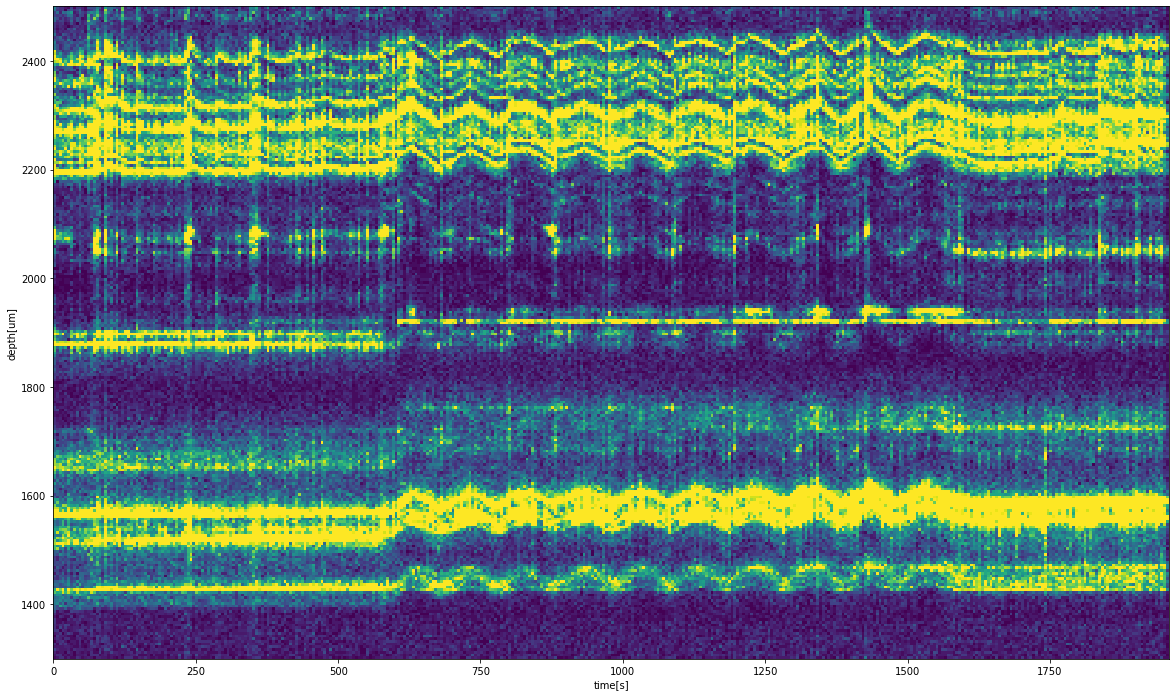

In [32]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], spatial_bins[0], spatial_bins[-1])
im = ax.imshow(
    motion_histogram.T,
    interpolation='nearest',
    origin='lower',
    aspect='auto',
    extent=extent,
)
im.set_clim(0, 30)
ax.set_ylim(1300, 2500)
ax.set_xlabel('time[s]')
ax.set_ylabel('depth[um]')


## pariwise displacement from the motion histogram


In [39]:
pairwise_displacement, pairwise_displacement_weight = compute_pairwise_displacement(motion_histogram, bin_um, method='conv2d', )
np.save(peak_folder / 'pairwise_displacement_conv2d.npy', pairwise_displacement)



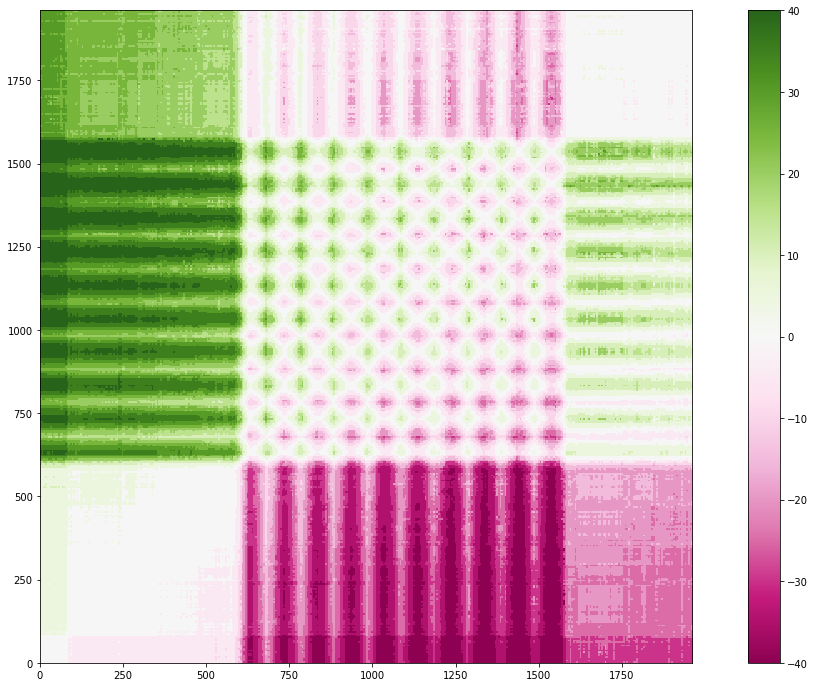

In [40]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], temporal_bins[0], temporal_bins[-1])
# extent = None
im = ax.imshow(
    pairwise_displacement,
    interpolation='nearest',
    cmap='PiYG',
    origin='lower',
    aspect='auto',
    extent=extent,
)
im.set_clim(-40, 40)
ax.set_aspect('equal')
fig.colorbar(im)

## estimate motion (rigid) from the pairwise displacement

In [43]:
motion = compute_global_displacement(pairwise_displacement)

motion = compute_global_displacement(pairwise_displacement,convergence_method='gradient_descent',)
# motion = compute_global_displacement(pairwise_displacement, pairwise_displacement_weight=pairwise_displacement_weight, convergence_method='lsqr_robust',)



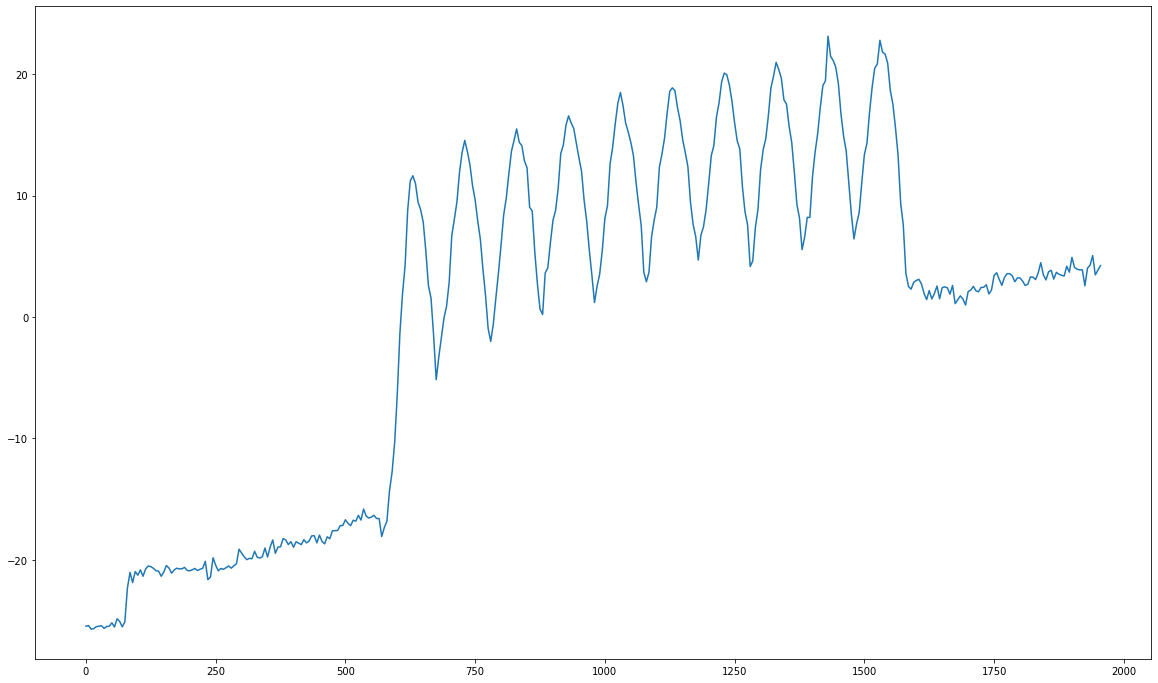

In [47]:
fig, ax = plt.subplots()
ax.plot(temporal_bins[:-1], motion)


## motion estimation with one unique funtion

Internally `estimate_motion()` does:
  * make_motion_histogram()
  * compute_pairwise_displacement()
  * compute_global_displacement()
  

In [58]:
from spikeinterface.sortingcomponents.motion_estimation import estimate_motion
from spikeinterface.widgets import plot_pairwise_displacement, plot_displacement

In [59]:
method='decentralized_registration'
method_kwargs = dict(

     pairwise_displacement_method='conv2d',
    # convergence_method='gradient_descent',
    convergence_method='lsqr_robust',
    
)

# method='decentralized_registration'
# method_kwargs = dict(
#     pairwise_displacement_method='phase_cross_correlation',
#     convergence_method='lsqr_robust',
# )


motion, temporal_bins, spatial_bins, extra_check = estimate_motion(
    rec_preprocessed,
    peaks,
    peak_locations=peak_locations,
    direction='y',
    bin_duration_s=5.,
    bin_um=10.,
    method=method,
    method_kwargs=method_kwargs,
    non_rigid_kwargs=None,
    output_extra_check=True,
    progress_bar=True,
    verbose=False,
)

100%|██████████| 392/392 [00:09<00:00, 40.71it/s]


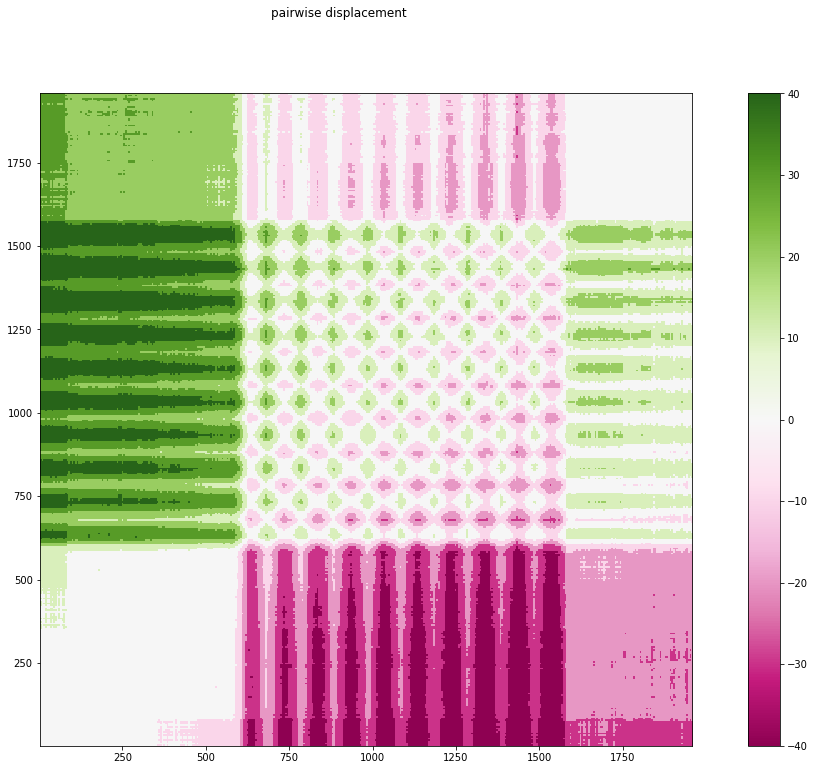

In [60]:
plot_pairwise_displacement(motion, temporal_bins, spatial_bins, extra_check, ncols=4)

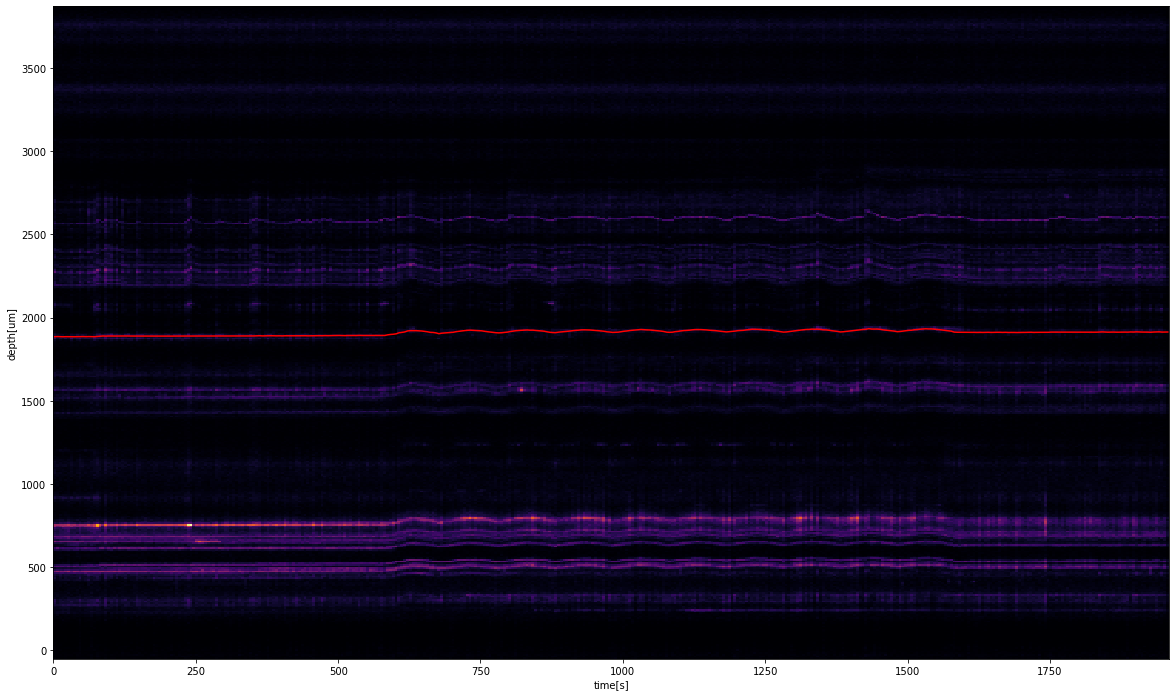

In [61]:
plot_displacement(motion, temporal_bins, spatial_bins, extra_check, with_histogram=True)

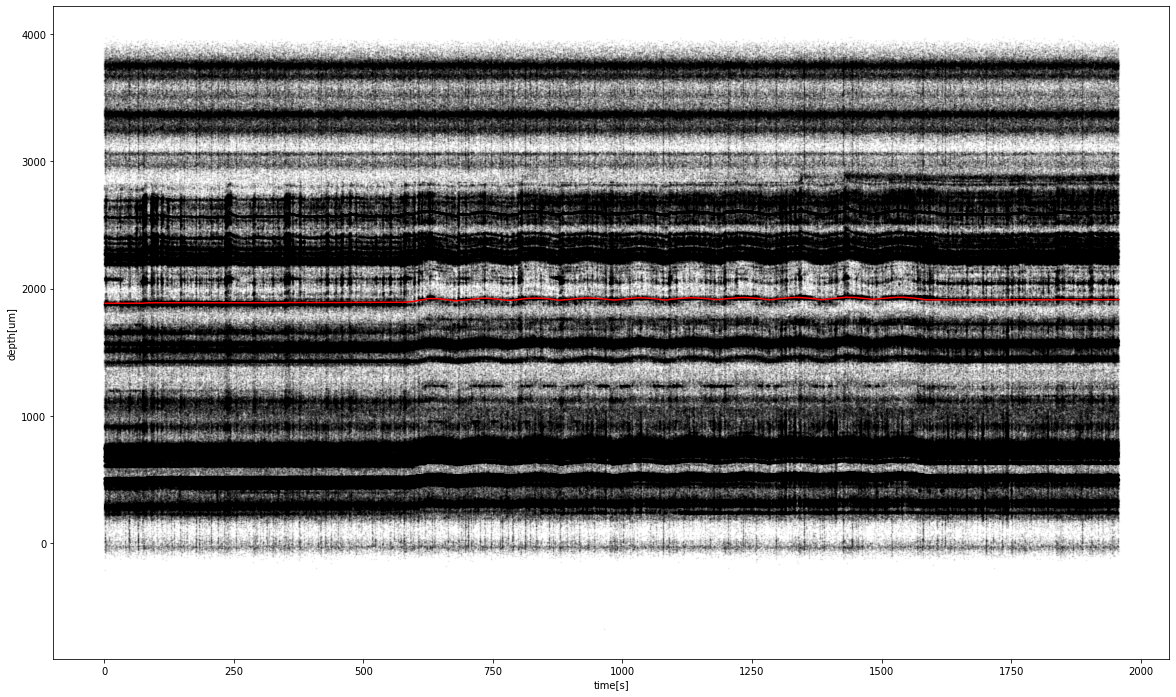

In [62]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
plot_displacement(motion, temporal_bins, spatial_bins, extra_check, with_histogram=False, ax=ax)

## motion estimation non rigid


In [64]:
# method='decentralized_registration'
# method_kwargs = dict()
#     pairwise_displacement_method='conv2d',
#     convergence_method='gradient_descent',
# )

method='decentralized_registration'
method_kwargs = dict(
    pairwise_displacement_method='conv2d',
    convergence_method='lsqr_robust',
)


# method='decentralized_registration'
# method_kwargs = dict(
#     pairwise_displacement_method='phase_cross_correlation',
#     convergence_method='lsqr_robust',
# )


motion, temporal_bins, spatial_bins, extra_check = estimate_motion(
    rec_preprocessed,
    peaks,
    peak_locations=peak_locations,
    direction='y',
    bin_duration_s=5.,
    bin_um=5.,
    method=method,
    method_kwargs=method_kwargs,
    non_rigid_kwargs=dict(bin_step_um=200, signam=3),
    output_extra_check=True,
    progress_bar=True,
    verbose=False,
)


100%|██████████| 392/392 [00:18<00:00, 21.25it/s]


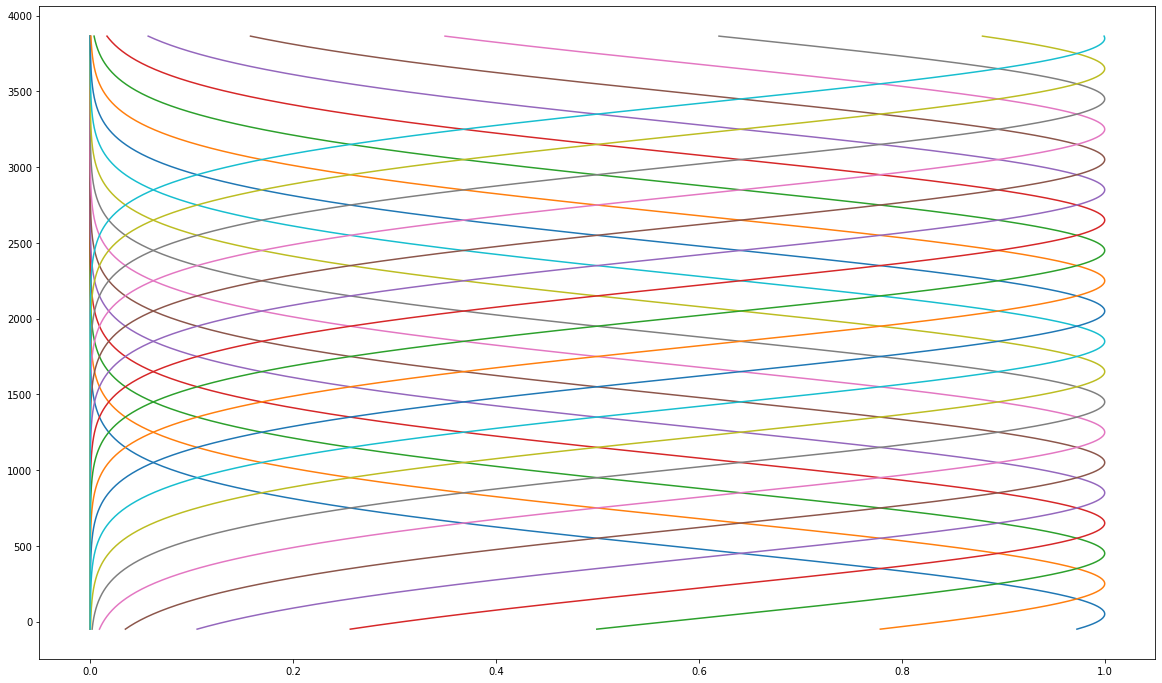

In [65]:
fig, ax = plt.subplots()
for win in extra_check['non_rigid_windows']:
    ax.plot(win, extra_check['spatial_hist_bins'][:-1])

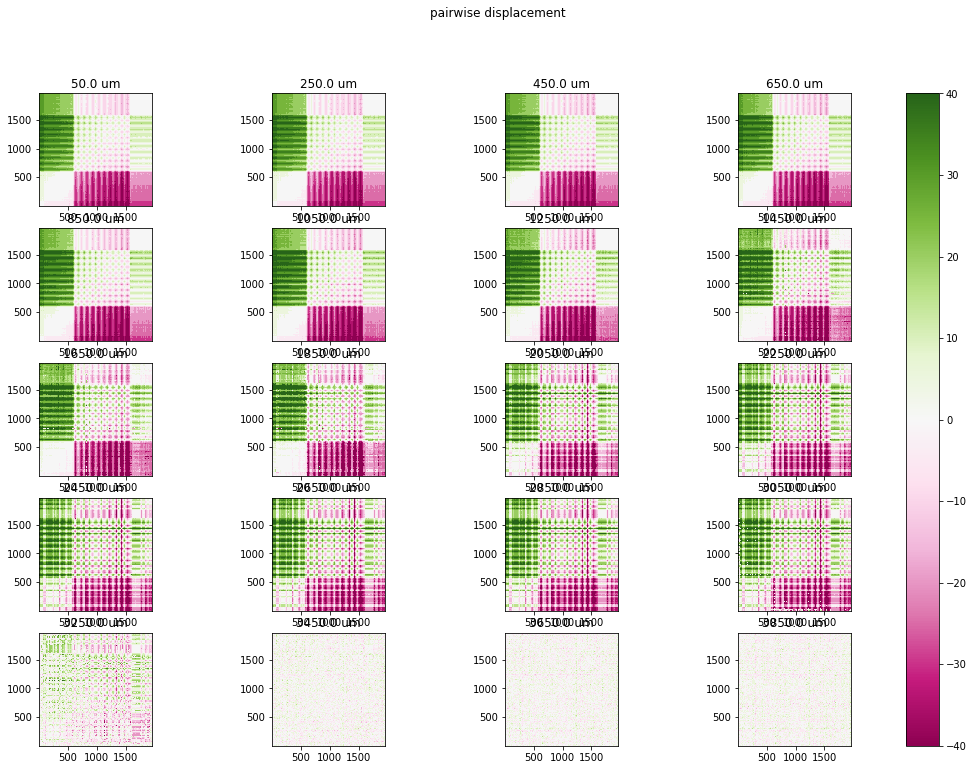

In [66]:
plot_pairwise_displacement(motion, temporal_bins, spatial_bins, extra_check, ncols=4)

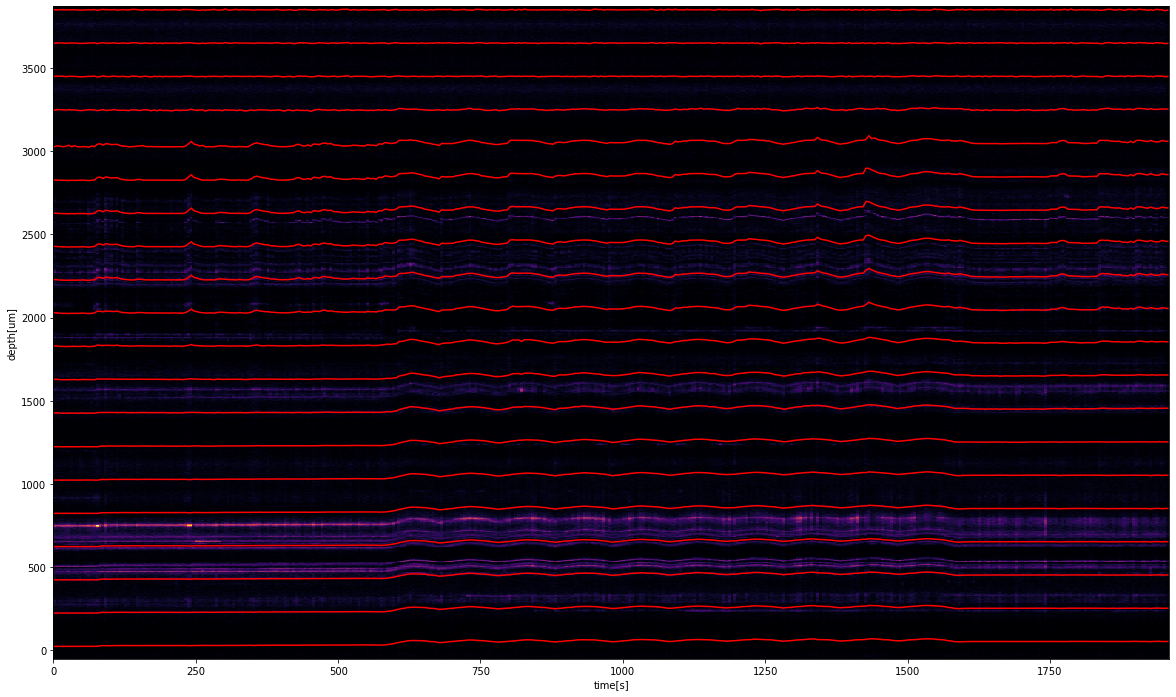

In [67]:
plot_displacement(motion, temporal_bins, spatial_bins, extra_check, with_histogram=True)

(0.0, 2000.0)

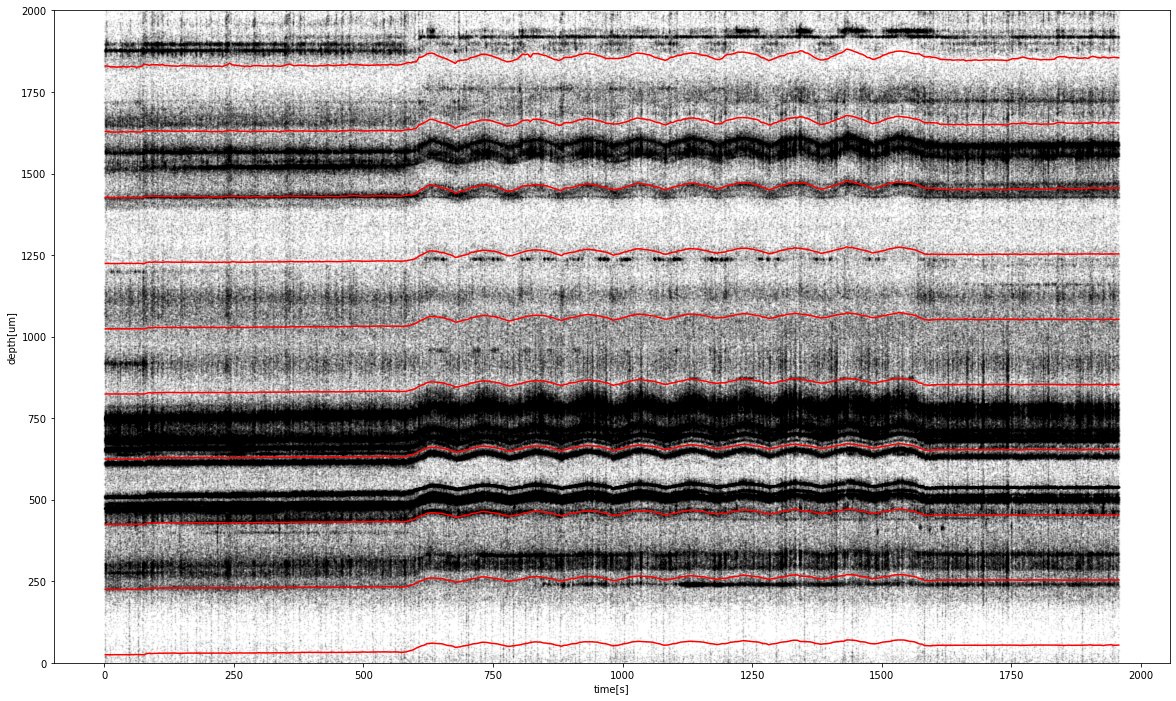

In [69]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
plot_displacement(motion, temporal_bins, spatial_bins, extra_check, with_histogram=False, ax=ax)
ax.set_ylim(0, 2000)

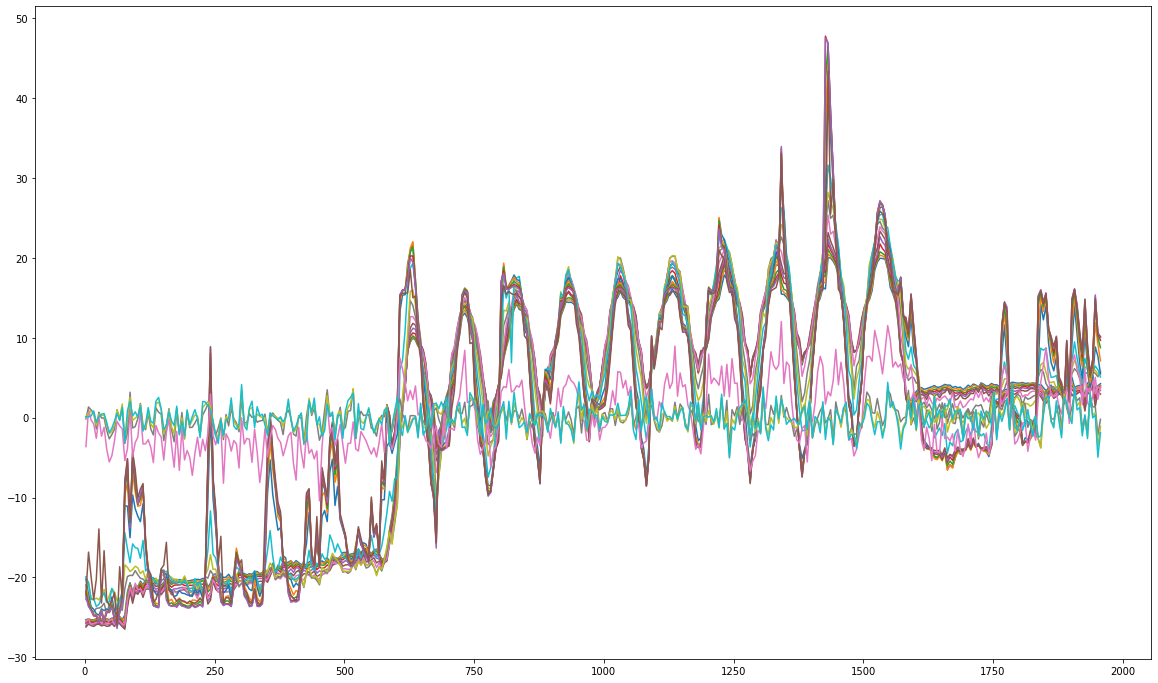

In [70]:
fig, ax = plt.subplots()
ax.plot(temporal_bins, motion)

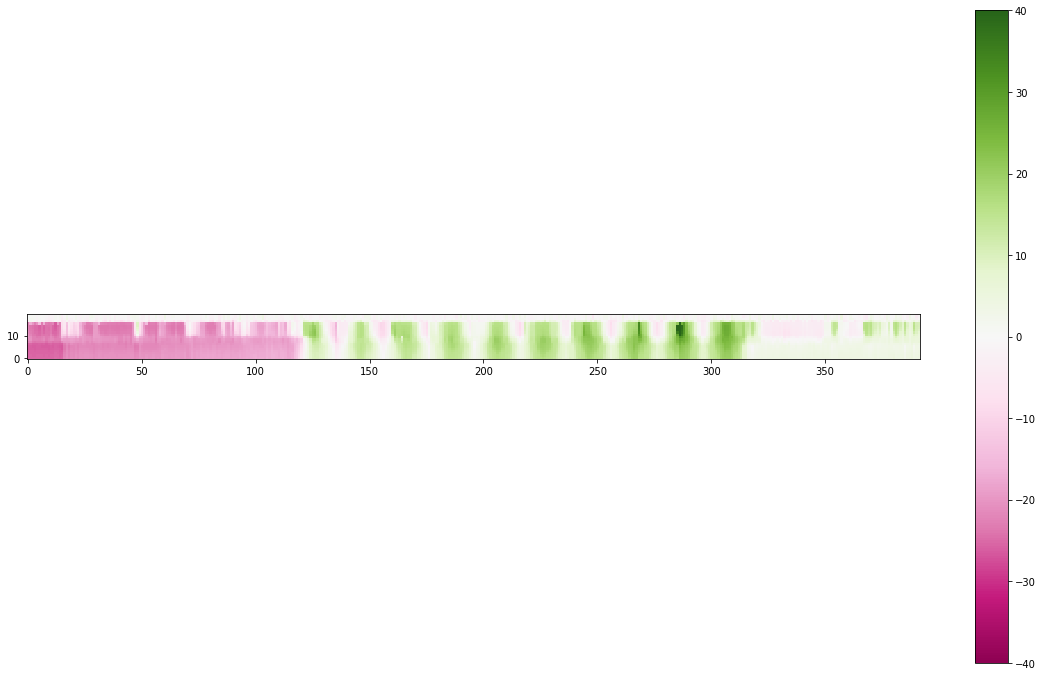

In [71]:
fig, ax = plt.subplots()
im = ax.imshow(motion.T,
    interpolation='nearest',
    cmap='PiYG',
    origin='lower',
    aspect='auto',
    # extent=extent,
)
im.set_clim(-40, 40)
ax.set_aspect('equal')
fig.colorbar(im)